<a href="https://colab.research.google.com/github/berkeyagizkiliccii/FSWeb-S2G4-JavaScript-tekrar/blob/main/Machine_Learning_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# Step 1: Load Libraries and Dataset
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

sns.set()

# featurelerin isimleri (education, marraige vb 2. satırda olduğu için headerı 1 ayarladık yani ilk satırı görmezden geldik)
df = pd.read_excel("default of credit card clients.xls", header=1)

# ID sütununu veri olarak işlevsiz olduğu için attık
#kopya oluşturmadan orijinal data üzerinde değişiklik yapıyoruz inplace=true

if "ID" in df.columns:
    df.drop(columns=["ID"], inplace=True)

# y nin ismi "default payment next month" olduğu için kısaltıp default dedik. 1 ödeme yapmayacak 0 yapacak
df.rename(columns={"default payment next month": "DEFAULT"}, inplace=True)




In [ ]:

# ==========================================
# Step 2: Preprocessing
# ==========================================

# Sütunların herhangi birinde eksik değer var mı baktık
print("\nMissing values per column:")
print(df.isnull().sum())

# Education için kaç tane benzersiz category var
print("\nEDUCATION value counts (before cleaning):")
print(df["EDUCATION"].value_counts())

# Marriage için kaç tane benzersiz category var
print("\nMARRIAGE value counts (before cleaning):")
print(df["MARRIAGE"].value_counts())

# 1=Lisansüstü 2=üniversite 3=Lise. 0 5 6 algoritmayı bozmasın diye other olarak adlandırdım
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})

# 1=evli 2=bekar bunlar 0 da vardı bunu other olarak adlandırdım
df["MARRIAGE"] = df["MARRIAGE"].replace({0: 3})

#cleaningden sonra kaç benzersiz var baktım
print("\nEDUCATION value counts (after cleaning):")
print(df["EDUCATION"].value_counts())

#cleaningden sonra kaç benzersiz var baktım
print("\nMARRIAGE value counts (after cleaning):")
print(df["MARRIAGE"].value_counts())

# target olarak imbalanceye bakarız. 0 ve 1lerin sayısına
print("\nTarget distribution (counts):")
print(df["DEFAULT"].value_counts())

# target olarak imbalanceye bakarız. 0 ve 1lerin oranına(normalize true)
print("\nTarget distribution (ratios):")
print(df["DEFAULT"].value_counts(normalize=True))
#imbalance var 0=0.7788 ödeme yapanlar 1=0.2212 ödeme yapmayanlar
#yani accuracy yetersiz kalır çünkü dataset imbalance



Missing values per column:
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

EDUCATION value counts (before cleaning):
EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

MARRIAGE value counts (before cleaning):
MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

EDUCATION value counts (after cleaning):
EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

MARRIAGE value counts (after cleaning):
MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

Target distribution (counts):
DEFAULT
0    23364
1     6636
Name: count, dtype: int64

Tar

In [ ]:

# ==========================================
# step 3)Split dataset 70 15 15
# ==========================================

X = df.drop("DEFAULT", axis=1) #son sütun(target hariç xe ata)
y = df["DEFAULT"] #targeti belirle

# 70 30 ilk bölme
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
#straify=y verdik çünkü imbalance durumun veri seti bölerken de aynı oranda korunmasını istedik
# 30u 15 15 bölme
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)




In [ ]:

# ==========================================
# Step 4: Feature Scaling
# ==========================================
#büyük ölçekli featureler (LIMIT_BAL=500000) küçük ölçekli featureleri (age=30) ezmesin diye scaling yapıyoruz
scaler = StandardScaler()
X_train_s=scaler.fit_transform(X_train)
#trainlerde fit yapıyoruz ama val ve testte fit yapmıyoruz çünkü test datasını öğrensin istemiyoruz
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)


In [ ]:

# ==========================================
# Step 5: Baseline Model – Logistic Regression
# ==========================================

log_reg = LogisticRegression(max_iter=1000, random_state=42) #default iterasyon sayısı 100 dür 100 tekrarda öğrenememe
#ihtimaline karşılık max tekrar sayısını 1000 yaptık
log_reg.fit(X_train_s, y_train)

y_pred_log = log_reg.predict(X_test_s) #tahminleri (0 mı 1 mi y ye kaydederiz)
y_prob_log = log_reg.predict_proba(X_test_s)[:, 1]
#predic_proba[[0.90, 0.10], [0.35, 0.65], gibi listeler döndürür
#1. eleman default yapmama(ödeme) ihtimali 2.eleman default yapma(ödememe) ihtimali
#buradan 2. sütunu yani default ödeme yapmama oranlarını alıp y_prob_log'a kaydediyoruz
#roc-auc için bu lazım

acc_log  = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log  = recall_score(y_test, y_pred_log)
f1_log   = f1_score(y_test, y_pred_log)
auc_log  = roc_auc_score(y_test, y_prob_log)

print("\n Logistic Regression – Test Performance")
print(classification_report(y_test, y_pred_log))
print(f"Accuracy : {acc_log:}") #model başarısı (imbalance dataset olduğı için yetersiz)
print(f"Precision: {prec_log:}") #ödeyecek dediklerinin nekadarı gerçekten ödeyecek
print(f"Recall   : {rec_log:}") #ödemeyecekler ödeyecek gözüktü mü
print(f"F1-Score : {f1_log:}") #pre rec harmonik ortalama
print(f"ROC-AUC  : {auc_log:.4f}") #sınıfları ayırma başarısını gösterir 0.7 ortalama başarılı




 Logistic Regression – Test Performance
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3504
           1       0.70      0.23      0.35       996

    accuracy                           0.81      4500
   macro avg       0.76      0.60      0.62      4500
weighted avg       0.79      0.81      0.77      4500

Accuracy : 0.8077777777777778
Precision: 0.6966966966966966
Recall   : 0.23293172690763053
F1-Score : 0.3491346877351392
ROC-AUC  : 0.7170


In [ ]:

# ==========================================
# Step 6: Initial Random Forest Model (Default Parameters)
# ==========================================

rf_base = RandomForestClassifier(random_state=42) #önce default parametrelerle base olarak random forest yaparız
rf_base.fit(X_train_s, y_train)

# Validation set üzerinde performans (tuning öncesi referans)
y_val_prob_base = rf_base.predict_proba(X_val_s)[:, 1] #sadece roc auc için olan predicti yapıyoruz
auc_rf_base_val = roc_auc_score(y_val, y_val_prob_base) #roc-auc hesaplama

print(f"\nInitial Random Forest – Validation ROC-AUC: {auc_rf_base_val:.4f}")
#Tune edilmemiş halinde bile random forest (0.75) logistic regresiondan (0.71) daha iyi
#çünkü non linear patternları random forest daha iyi öğreniyor



Initial Random Forest – Validation ROC-AUC: 0.7571


In [ ]:

# ==========================================
# Step 7  Tuning
# ==========================================

# Train + Validation birleştiriyoruz hangisinin train hangisin val dataları olduğunu belirteceğiz
X_train_val_s = np.vstack([X_train_s, X_val_s]) #x_train_val_s değişkeninde hem train hem val datalarını birleştirdik
y_train_val   = np.concatenate([y_train, y_val]) #y nin train validate datalarını da birleştirdik

#default k-fold-cross validation yapmaması için bizim istediğimiz gibi yüzde 15le validation yapması için:
##train veri sayısı kadar -1 validation veri sayısı kadar 0 yazdık
test_fold = np.array([-1] * len(X_train_s) + [0] * len(X_val_s))
ps = PredefinedSplit(test_fold)
# PredefinedSplit: -1 olan indeksleri train, 0 olan indeksleri validation olarak kabul eden bir split objesi oluşturur.


# proje dosyasındaji parametreleri dictionary içinde veriyoruz
param_dist = {
    "n_estimators": [100, 200, 300, 500], #4 farklı ağaç sayısı belirleyip hepsini tek tek deneyip en iyisini seç
    "max_depth": [None, 5, 10, 15, 20], #5 farklı ağaç derinliği sayısıyla dene bir tanesi sınırsız derinlik
    "max_features": ["sqrt", "log2", 0.5],
#split yaparken featureler arasında impurity hesaplaması yapar her bir splitte kaç zaten feature arasından feature seçeceğini belirler
#her splite verilecek feature sayısı için: birinde toplam featurenin karekökü kadar birinde log2si kadar birinde de yarısı kadar
#model elde kalan featureler üzerinden random bir şekilde bukadar feature seçer
#elde kalan feature sayısı burada kalan kadar yoksa kalan kadar feature seçilir
    "min_samples_leaf": [1, 2, 4, 8],
#Leaf node’un içindeki örneklerin çoğunluğu hangi sınıftaysa, model o sınıfı output verir.
#her bir ağacın leaf node'unda minimum kaç kişi olması gerektiği
}

rf = RandomForestClassifier(random_state=42)#boş eğitimsiz bir model daha oluşturduk

rf_search = RandomizedSearchCV(  #tuning
    estimator=rf, #tuning yapılacak model
    param_distributions=param_dist, #yukarıda oluşturduğumuz parametre kurallarını verdik
    n_iter=20, #toplam 20 farklı parametre kombinasyonunu dene
    scoring="roc_auc", #hani kombinasyonda roc auc en yüksekse onu seç
    cv=ps, #cross-validationu kendi 15 15 bölerek yukarıda yaptığımı burada verdim
    random_state=42,
    n_jobs=-1, #tüm cpu çekirdeklerini kullan
    verbose=1 #
)

rf_search.fit(X_train_val_s, y_train_val) #tuningi başlattık

print("\nBest Parameters from RandomizedSearchCV:")
print(rf_search.best_params_) #RandomizedSearch ün içinde best_paramsda en iyi parametre kombinasyonu tutulur
print(f"Best Validation ROC-AUC: {rf_search.best_score_:}") #tuningden sonra best roc auc 0.7750 çıktı başta 0.75di

# best_estimator_ train+val üzerinde yeniden eğitilmiş durumdadır
best_rf = rf_search.best_estimator_ #hyperparameter'ı optimize edilmiş travin validation verisiyle eğitilmiş tahmin yapmaya hazır nihai model


Fitting 1 folds for each of 20 candidates, totalling 20 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 500, 'min_samples_leaf': 8, 'max_features': 0.5, 'max_depth': 10}
Best Validation ROC-AUC: 0.7750011111190762


In [ ]:

# ==========================================
# Step 8: Final Random Forest Test Performance
# ==========================================

y_pred_rf = best_rf.predict(X_test_s) #1 ve 0 lardan oluşan tahmin çıktıları
y_prob_rf = best_rf.predict_proba(X_test_s)[:, 1] #1 in ve 0 ın ihtimallerinden oluştan tahmin çıktıları

acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
auc_rf  = roc_auc_score(y_test, y_prob_rf)

print("\n=== Random Forest (Tuned) – Test Performance ===")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy : {acc_rf:}")
print(f"Precision: {prec_rf:}")
print(f"Recall   : {rec_rf:}")
print(f"F1-Score : {f1_rf:}")
print(f"ROC-AUC  : {auc_rf:.4f}")



=== Random Forest (Tuned) – Test Performance ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3504
           1       0.67      0.35      0.46       996

    accuracy                           0.82      4500
   macro avg       0.75      0.65      0.68      4500
weighted avg       0.80      0.82      0.80      4500

Accuracy : 0.8177777777777778
Precision: 0.6666666666666666
Recall   : 0.3534136546184739
F1-Score : 0.46194225721784776
ROC-AUC  : 0.7795


In [ ]:

# ==========================================
# Step 9 Comparison
# ==========================================

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest (Tuned)"],
    "Accuracy": [acc_log, acc_rf],
    "Precision": [prec_log, prec_rf],
    "Recall": [rec_log, rec_rf],
    "F1-Score": [f1_log, f1_rf],
    "ROC-AUC": [auc_log, auc_rf]
})

print("\nPerformance Comparison Table:")
print(results)
#Accuracy:random forest non linear öğrenebildiği için doğruluğu daha iyi ama yine de küçük bir fark var. #imbalanced datasete yetersiz bir metric
#Precision:Logistic reg daha iyi. Bu logistic regin daha temkinli yaklaşmasından olabilir yani daha az kişiye default edecek der o yüzden daha sık haklı çıkıyor
#     yani yanlış alarm daha çok ödemeyecek dedik ama kişi ödemiş.
#     Bankacılık sisteminde yanlış alarmın fazla olması banka açısından faydalı olabilir daha sık bir elemeden geçirir
#     Bir yandan da iyi müşteriler reddedilip kar ihtimali de düşebilir
#     Random forest daha agresif davranıp daha çok kişiye default diyor o yüzden kesinliği biraz düşük çıkmış
#Recall: Gerçek ödemeyecek kişilerin yakalanma oranında ikisi de düşük ama random forest belirgin bir şekilde daha yüksek
#F1-Score:pre rec harmonik ortalaması random forest anlamlı bir şekilde daha yüksek
#Roc-auc:imbalanced datasetlerde en önemli metriclerdendir ve random forest anlamlı bir şekilde daha yüksektir
#genel olarak random forestın daha iyi olmasını nonlinear patternları daha iyi anlamasına bağlayabiliriz


Performance Comparison Table:
                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0    Logistic Regression  0.807778   0.696697  0.232932  0.349135  0.717033
1  Random Forest (Tuned)  0.817778   0.666667  0.353414  0.461942  0.779498


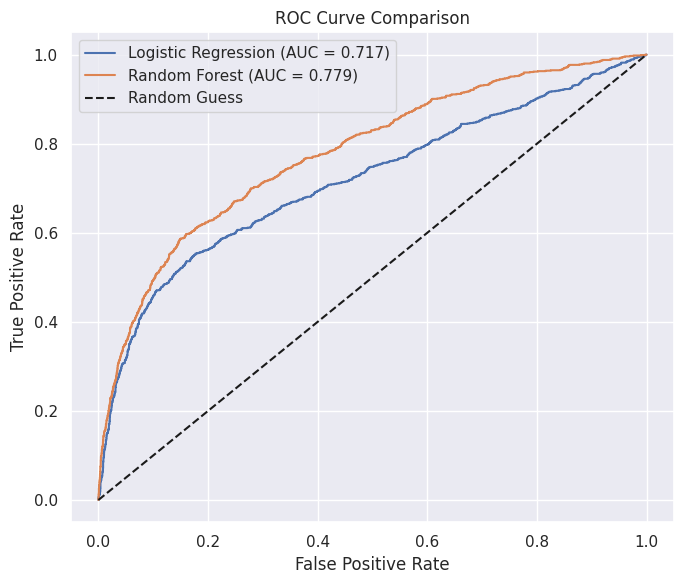

In [ ]:

# ==========================================
# Step 10  ROC Curve Comparison
# ==========================================

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()
#genel olarak random forest sınıfları (default non default) daha iyi ayırır

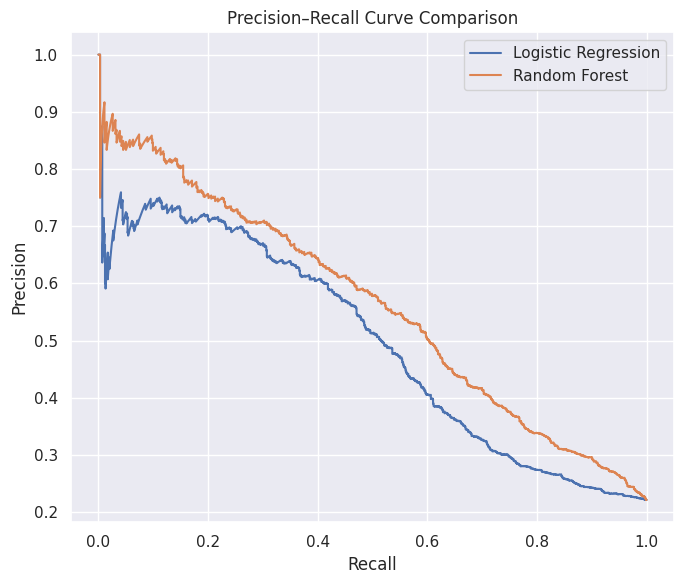

In [ ]:

# ==========================================
# Step 11 Precision–Recall Curve Comparison
# ==========================================

prec_log_curve, rec_log_curve, _ = precision_recall_curve(y_test, y_prob_log)
prec_rf_curve,  rec_rf_curve,  _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(7, 6))
plt.plot(rec_log_curve, prec_log_curve, label="Logistic Regression")
plt.plot(rec_rf_curve,  prec_rf_curve,  label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()
#yine random forestın daha iyi olduğu gözükür


Top Featuress' Importance
PAY_0        0.351443
PAY_2        0.134916
PAY_3        0.058178
BILL_AMT1    0.038792
LIMIT_BAL    0.035108
PAY_AMT3     0.032278
PAY_AMT2     0.030425
PAY_AMT1     0.029425
PAY_5        0.027660
AGE          0.027626
PAY_4        0.026929
PAY_AMT6     0.024504
BILL_AMT2    0.023311
PAY_AMT4     0.023272
PAY_AMT5     0.022271
BILL_AMT6    0.021896
BILL_AMT3    0.020719
BILL_AMT5    0.020068
BILL_AMT4    0.019457
PAY_6        0.015895
EDUCATION    0.008330
SEX          0.003878
MARRIAGE     0.003619
dtype: float64


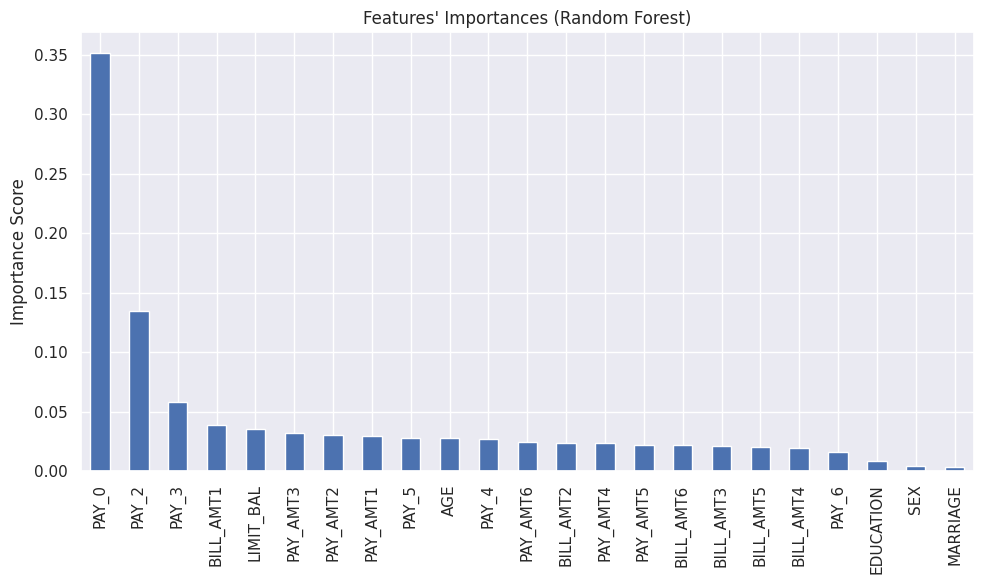

In [ ]:

# ==========================================
# Step 12: Feature Importance Analysis
# ==========================================

importances = best_rf.feature_importances_  #
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\nTop Featuress' Importance")
print(feat_imp.head(23))

plt.figure(figsize=(10, 6))
feat_imp.head(23).plot(kind="bar")
plt.title("Features' Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
